# Word Usage Graphs

See [the tutorial](aiid-api.ipynb) on the code below. Skip to: [Code](#Code), [AI Trends](#AI-Trends), [Concerns](#Concerns)

## Code

In [2]:
import requests
import json
import matplotlib.pyplot as plt 

def post_query(query, variables={}):
    response = requests.post(
        'https://incidentdatabase.ai/api/graphql',
        data=json.dumps({ "query": query, "variables": variables }),
        headers={"content-type": "application/json"}
    )
    response_json = response.json()
    if response_json.get('errors'):
        raise Exception(response_json['errors'])
    return response_json['data']

def get_keyword_usage_over_time_batched(keywords, start_year=2012, end_year=2024, binsize=4):
    result = {}
    query = "query {"
    
    for i, keyword in enumerate(keywords):
        for year in range(start_year, end_year, binsize):
            lower = str(year)
            upper = str(year + binsize)
        
            query += (
                """
                  __KEY__:
                  reports(
                    filter: {
                      plain_text: { REGEX: "__KEYWORD__"},
                      date_published: {
                        GTE: "__PUBLISHED_GTE__",
                        LT: "__PUBLISHED_LT__"
                      }
                    }
                  ) {
                    report_number
                  }
                """
                .replace("__KEYWORD__", "\\\\W(?i)" + keyword +"\\\\W")
                .replace("__PUBLISHED_GTE__", lower + "-01-01T00:00:00+00:00")
                .replace("__PUBLISHED_LT__", upper + "-01-01T00:00:00+00:00")
                .replace("__KEY__", "keyword" + str(i) + lower + upper)
            )
    query += "\n}"
    data = post_query(query)
    result = {}
    for i, keyword in enumerate(keywords):
        result[keyword] = {}
        for year in range(start_year, end_year, binsize):
            lower = str(year)
            upper = str(year + binsize)
            range_string = lower + "-" + upper if binsize > 1 else lower

            result[keyword][range_string] = len(data["keyword" + str(i) + lower + upper])
    return result

def make_graph(keyword_usage):
    fig = plt.figure(figsize = (10, 5))
    for keyword in keyword_usage.keys():
        plt.plot( keyword_usage[keyword].keys(), keyword_usage[keyword].values() )

    plt.legend(keyword_usage.keys(), shadow=True)
    plt.xlabel("Years")
    plt.ylabel("No. of reports containing keyword")
    plt.title("Keyword Usage")
    plt.show()

def make_graph_relative(keyword_usage):
    fig = plt.figure(figsize = (10, 5))
    for keyword in keyword_usage.keys():
        if keyword == ".*": continue
        plt.plot( 
            keyword_usage[keyword].keys(), 
            [100 * e / list(keyword_usage[".*"].values())[i] for i, e in enumerate(keyword_usage[keyword].values())]
        )

    plt.legend(keyword_usage.keys(), shadow=True)
    plt.xlabel("Years")
    plt.ylabel("% of reports containing keyword")
    plt.title("Keyword Usage")
    plt.show()

def graph_keywords_over_time(keywords, start_year=2012, end_year=2024, binsize=1, relative=False):
    if relative:
        data = get_keyword_usage_over_time_batched(
            list(keywords) + [".*"], # Matches any word
            start_year=start_year, 
            end_year=end_year,
            binsize=binsize,
        )
        make_graph_relative(data)
    else:
        data = get_keyword_usage_over_time_batched(
            keywords, 
            start_year=start_year, 
            end_year=end_year,
            binsize=binsize,
        )
        make_graph(data)

## AI Trends

### Generative AI

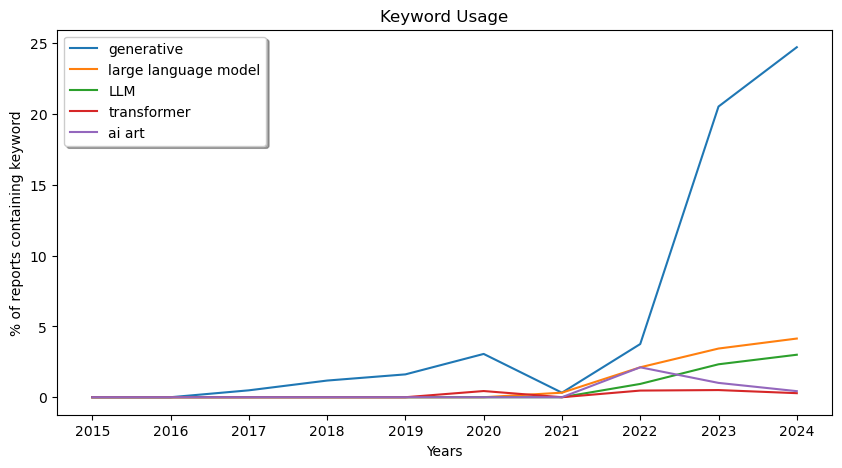

In [79]:
graph_keywords_over_time(
    ("generative", "large language model", "LLM", "transformer", "ai art"),
    relative=True, start_year=2015, end_year=2025
)

### AI Responsibility

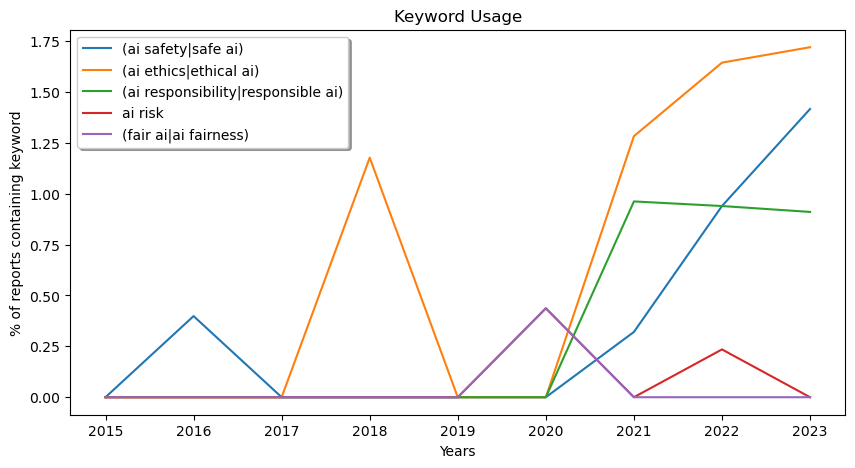

In [51]:
graph_keywords_over_time(
    ("(ai safety|safe ai)", "(ai ethics|ethical ai)", "(ai responsibility|responsible ai)", 
     "ai risk", "(fair ai|ai fairness)"),
    relative=True, start_year=2015
)

### Tech companies and the rise of OpenAI

The top companies represented in AIID reports have remained mostly constant, with the exception of OpenAI, which went from unmentioned in 2019 to the most referenced company in 2023.

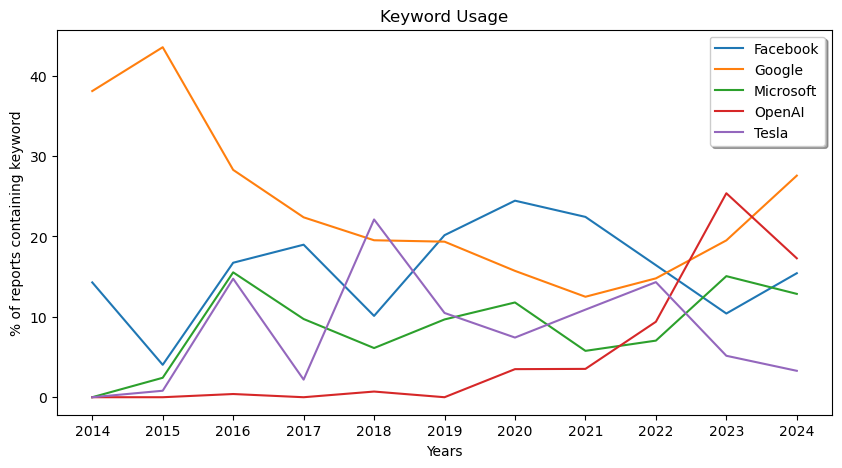

In [83]:
graph_keywords_over_time(("Facebook", "Google", "Microsoft", "OpenAI", "Tesla"), relative=True, start_year=2014, end_year=2025)

### The decline of machine learning?

Even though machine learning systems are more widespread than ever, the term "machine learning" has declined relative to "artificial intelligence" over the past six years. This is probably because the systems in question are increasingly discussed by the general public, which is less likely to use the more technical term.

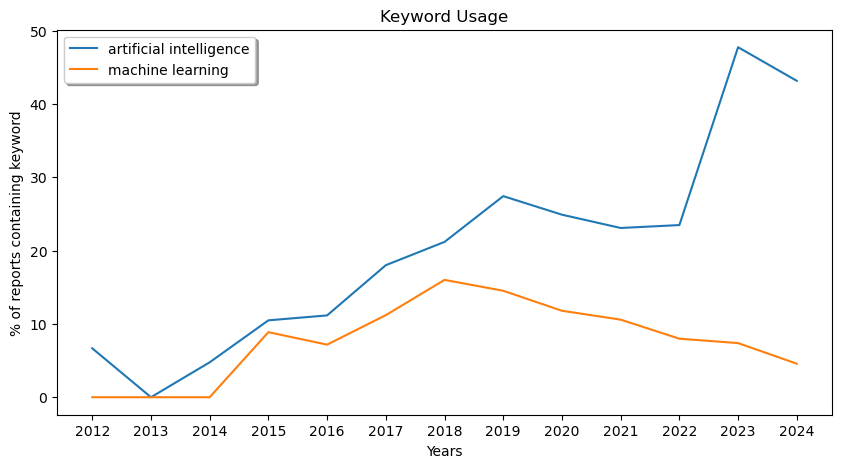

In [94]:
graph_keywords_over_time(("artificial intelligence", "machine learning"), relative=True, end_year=2025)

## Concerns

Over the past 5-10 years, we've seen an increase in mentions of misinformation, children, and mental health. We've seen a decrease in mentions of physical injuries, and mentions of prejudice are holding steady.

### Physical Injuries

Many incidents in the AIID concern physical injuries caused by self-driving cars or robots. However, words relating to these topics have declined in reports since 2018.

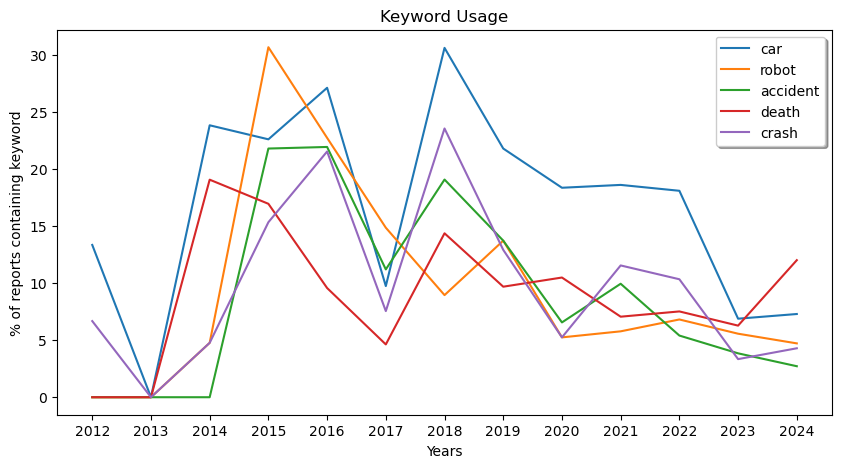

In [56]:
graph_keywords_over_time(
    ("car", "robot", "accident", "death", "crash"),
    relative=True, end_year=2025
)

### Misinformation

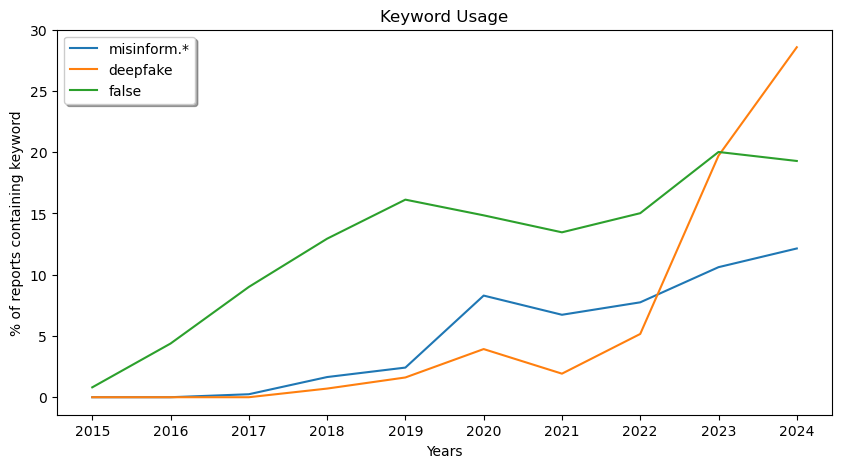

In [71]:
graph_keywords_over_time(
    ("misinform.*", "deepfake", "false"),
    relative=True, start_year=2015, end_year=2025
)

### Mental Health

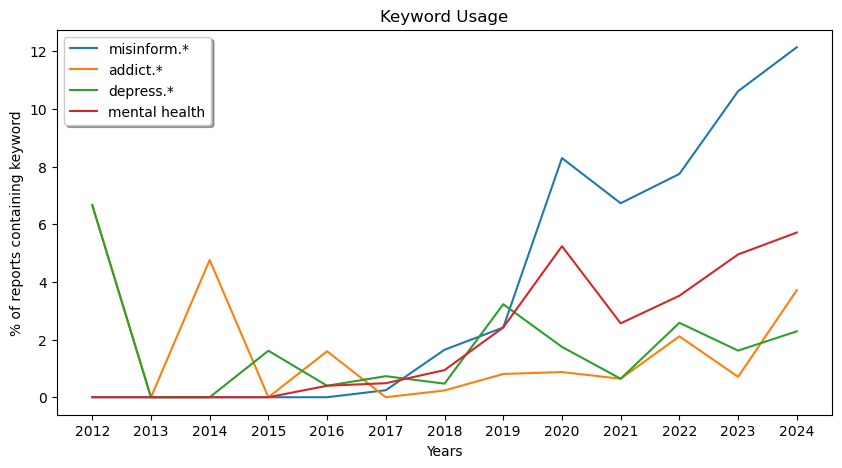

In [66]:
graph_keywords_over_time(
    ("addict.*", "depress.*", "mental health"),
    relative=True, end_year=2025
)

### Children

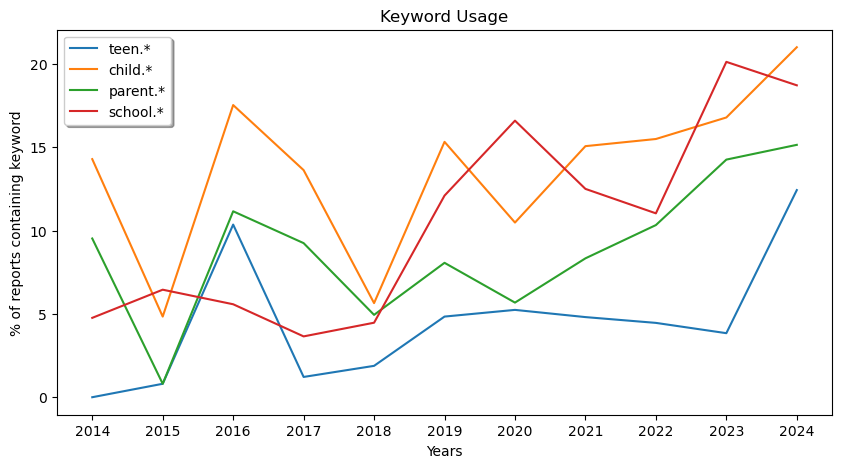

In [64]:
graph_keywords_over_time(
    ("teen.*", "child.*", "parent.*", "school.*"),
    relative=True, start_year=2014, end_year=2025
)

### Discrimination and Social Prejudices

Words concerning social prejudices spiked in 2016 but have otherwise been fairly constant. There's more diversity in the types of prejudice discussed in later reports, however.

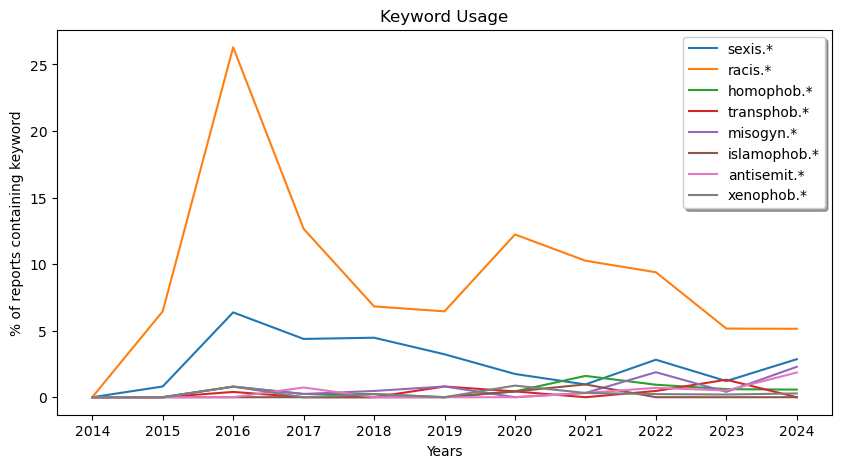

In [37]:
graph_keywords_over_time(
    ("sexis.*", "racis.*", "homophob.*", "transphob.*", "misogyn.*", "islamophob.*", "antisemit.*", "xenophob.*"), 
    relative=True, start_year=2014, end_year=2025
)

#### Gender

The reports in the AIID show a lot of concern about sexism.
How evenly do they represent men and women?
Languages with gendered pronouns provide a delightfully blunt instrument for measuring gender representation:

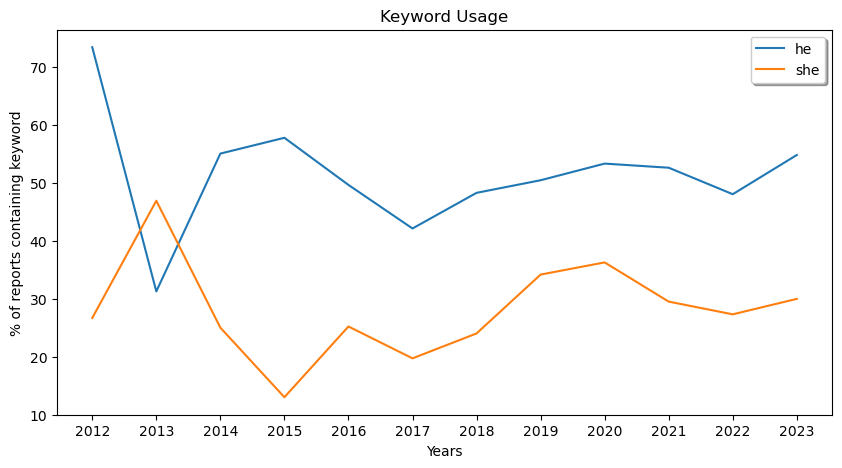

In [39]:
graph_keywords_over_time(("he", "she"), relative=True)

"He" appears more than "she", and this is basically constant over time. We find basically the same thing with "man" vs "woman."

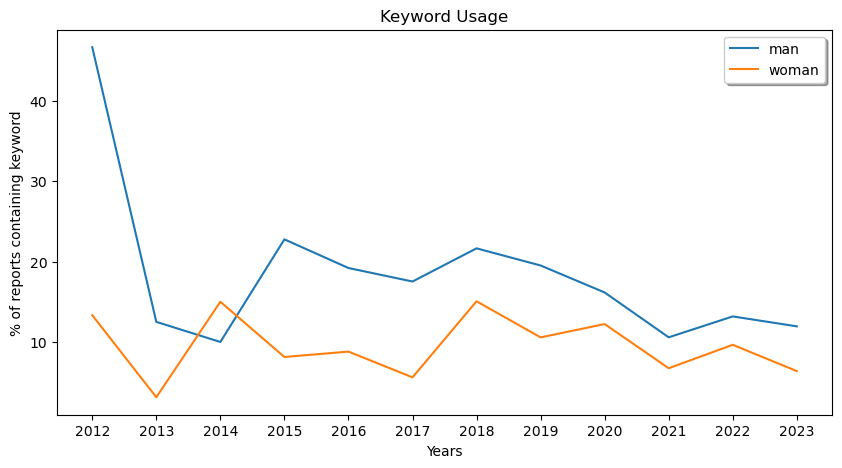

In [38]:
graph_keywords_over_time(("man", "woman"), relative=True)

However, when we use the plurals, "women" consistently appears more often than "men." Perhaps this is because while reports are more likely to mentioned individual men, they're more likely to talk about the collective concerns of women, as in ["UK passport photo checker shows bias against dark-skinned women"](https://incidentdatabase.ai/cite/87/#r1387).

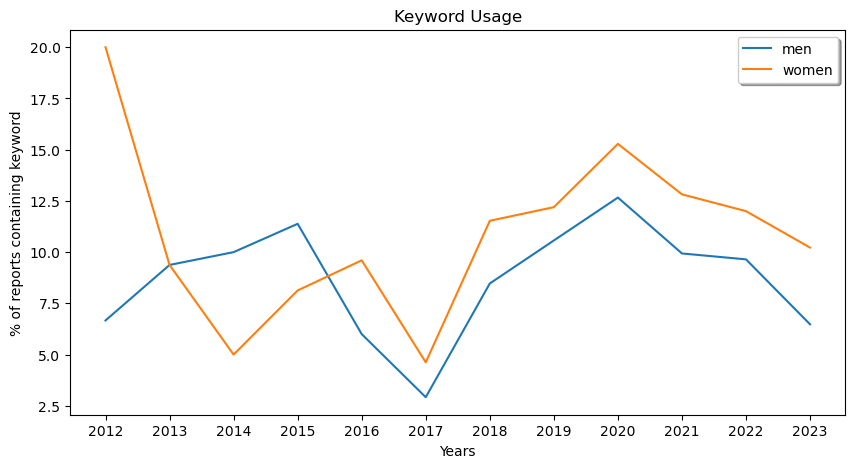

In [37]:
graph_keywords_over_time(("men", "women"), relative=True)

#### Religious Groups

Jews and Muslims are mentioned more than other religious groups, likely because of increased vulnerability or perceived vulnerability to discrimination. (Using plural forms because "Christian" frequently appears as a name.)

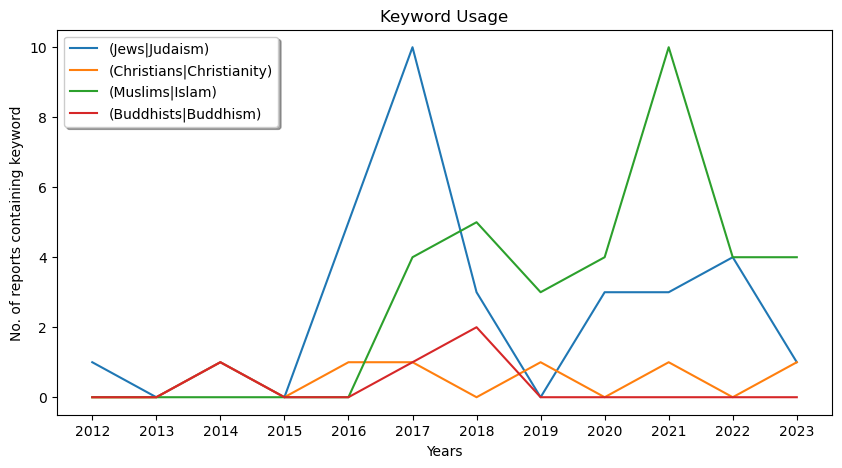

In [12]:
graph_keywords_over_time(
    ("(Jews|Judaism)", "(Christians|Christianity)", "(Muslims|Islam)", "(Buddhists|Buddhism)")
)

## Misc

### US Presidents

Weirdly, Obama was mentioned more often than Trump during some of Trump's own term, and Biden has never surpassed Trump in mentions even after replacing him as president. Trump and Obama seem to have hold more of a celebrity status than other presidents.

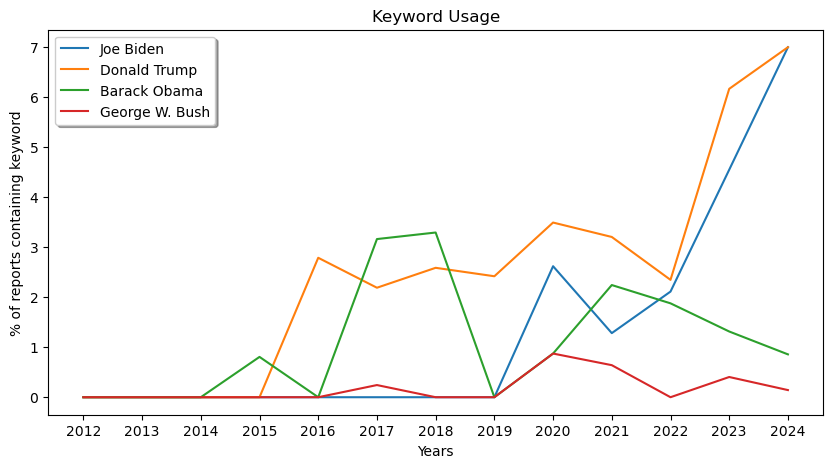

In [88]:
graph_keywords_over_time(("Joe Biden", "Donald Trump", "Barack Obama", "George W. Bush"), relative=True, end_year=2025)